In [96]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm
import seaborn as sns
import lightgbm as lgb
import warnings
from pylab import rcParams

rcParams['figure.figsize'] = 8, 5
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-whitegrid')

#### 1.Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

In [7]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [71]:
df.set_index('Time', append=True, inplace=True)

In [72]:
df.head()

PJME_MW  year  month  dayofmonth  quarter  dayofyear  \
Date       Time                                                             
2002-01-01 01:00:00  30393.0  2002      1           1        1          1   
           02:00:00  29265.0  2002      1           1        1          1   
           03:00:00  28357.0  2002      1           1        1          1   
           04:00:00  27899.0  2002      1           1        1          1   
           05:00:00  28057.0  2002      1           1        1          1   

                     weekofyear  dayofweek  hour  is_holiday  is_prev_holiday  \
Date       Time                                                                 
2002-01-01 01:00:00           1          1     1           1                0   
           02:00:00           1          1     2           1                0   
           03:00:00           1          1     3           1                0   
           04:00:00           1          1     4           1                0   
           05:00:00           1          1     5           1                0   

                     is_next_holiday   expon_PJME  
Date       Time                                    
2002-01-01 01:00:00                0  30393.00000  
           02:00:00                0  30336.60000  
           03:00:00                0  30237.62000  
           04:00:00                0  30120.68900  
           05:00:00                0  30017.50455

In [15]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [42]:
def split_data_b(data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [59]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
df['expon_PJME'] = exponential_smoothing(df['PJME_MW'], 0.05)

In [43]:
h = 1

In [111]:
train_b, test_b = split_data_b(df, '10-01-2016')

X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

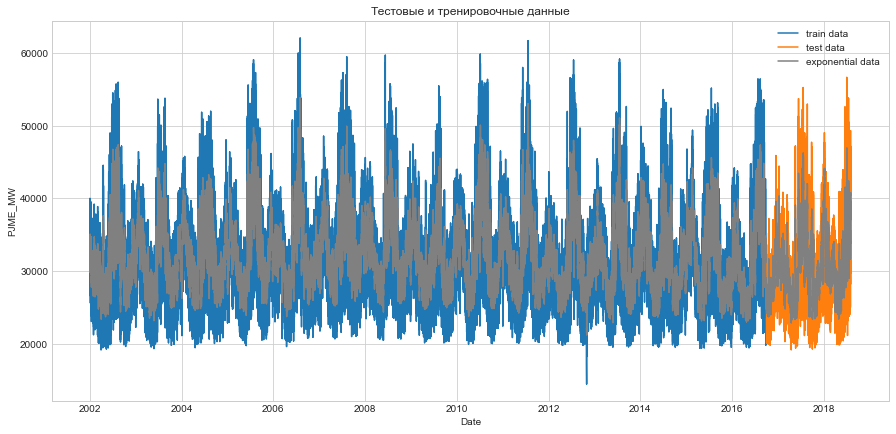

In [74]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.plot(train_b.index.get_level_values('Date'),train_b['PJME_MW'], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b['PJME_MW'], label='test data')
plt.plot(df.index.get_level_values('Date'),df['expon_PJME'], label='exponential data', color = 'grey')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [76]:
# Протестируем LightGBM
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train_b, y_train_b)
lgb_eval = lgb.Dataset(X_test_b, y_test_b, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
X_test_pred_gb = gbm.predict(X_test_b)

Starting training...
[1]	valid_0's l2: 3.42727e+07	valid_0's l1: 4709.74
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 3.10097e+07	valid_0's l1: 4481
[3]	valid_0's l2: 2.80656e+07	valid_0's l1: 4263.86
[4]	valid_0's l2: 2.54081e+07	valid_0's l1: 4058.23
[5]	valid_0's l2: 2.29998e+07	valid_0's l1: 3862.44
[6]	valid_0's l2: 2.08831e+07	valid_0's l1: 3681.16
[7]	valid_0's l2: 1.89205e+07	valid_0's l1: 3505.1
[8]	valid_0's l2: 1.71471e+07	valid_0's l1: 3338.17
[9]	valid_0's l2: 1.55455e+07	valid_0's l1: 3179.52
[10]	valid_0's l2: 1.40955e+07	valid_0's l1: 3028.49
[11]	valid_0's l2: 1.27825e+07	valid_0's l1: 2885.7
[12]	valid_0's l2: 1.15944e+07	valid_0's l1: 2749.51
[13]	valid_0's l2: 1.05248e+07	valid_0's l1: 2620.58
[14]	valid_0's l2: 9.56199e+06	valid_0's l1: 2498.68
[15]	valid_0's l2: 8.68856e+06	valid_0's l1: 2382.97
[16]	valid_0's l2: 7.89535e+06	valid_0's l1: 2272.75
[17]	valid_0's l2: 7.17716e+06	valid_0's l1: 2168.2
[18]	valid_0's l2: 6.52823e+06	va

In [91]:
er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)
er_g

6.50044346657241

In [94]:
#Протестируем GradientBoostingRegressor
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

er_g1 = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)
er_g1

0.8512410712540059

In [112]:
test_b2 = test_b.reset_index(level='Time')
df2 = df.reset_index()
df2.set_index('Date', inplace=True)

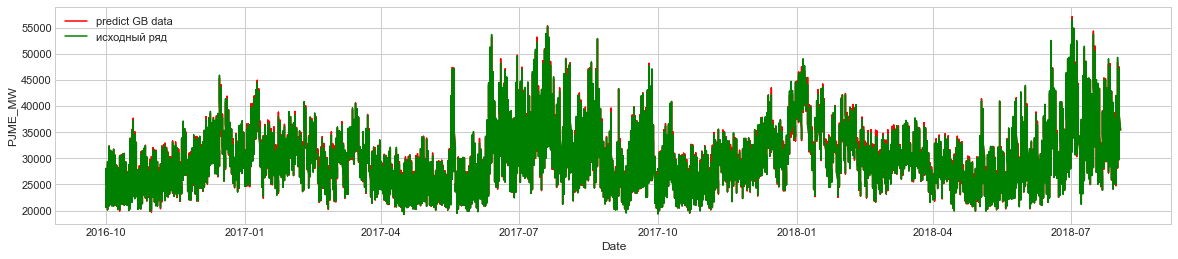

In [120]:
plt.figure( figsize=( 20, 4 ))

plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.plot(test_b2.index[1:],X_test_pred_gb, label='predict GB data', color='red')
plt.plot(df2.loc['10-01-2016':].index, df2.loc['10-01-2016':]['PJME_MW'], label='исходный ряд', color='green')
plt.legend()
plt.show()

In [121]:
h = 10
train_b, test_b = split_data_b(df, '10-01-2016')

X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

In [122]:
#Протестируем GradientBoostingRegressor
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)
er_g

4.883555099842132

#### 2.Оцените ошибку модели из п.1 .

- оценил выше - при h=1 ошибка ниже, чем при h=10

#### 3.Сделайте вывод о том, как изменилась ошибка модели по значениям h.

- Ошибка увеличилась в 5 раз с ростом горизонта прогноза. Следовательно, более точные данные мы получим, если отсавим горизонт прогноза равным 1
- Предсказание лучше оказалось в модели GradientBoostingRegressor, чем в LightGBM - возможно, из-за плохо настроенных параметров LightGBM

#### 4.Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):
а) Изменение температуры за окном :).

- не стационарный, если смотреть на температуру в течение года, но т.к. он цикличен, то за столетие вполне может быть и стационарным. 

б) Количество денег, которые тратят покупатели в интернет магазине.

- не стационарен, поскольку в магазине могут продаваться разные товары, влияет и сезон + инфляция вносит свой вклад. Тренд может быть разным, но с учетом инфляции у стабильного магазина он восходящий. Он может быть стационарным, если посмотреть небольшой период (месяц-два) с примерно одинаковым ассортиментом, затратами на рекламу и без сильных изменений курса валют.

в) Вес растущего котенка.

- не стационарен, т.к. вес котенка растет со временем. Имеет восходящий тренд

г) Прирост объема деревьев в лесу от времени

- стационарен, если под объемом имеется в виду именно сумма объемов каждого дерева. Скорей всего подвержен сезонным колебаниям, но возможно, что зависит от местоположения.